# Image classification

## Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Define some parameters for the loader:

In [2]:
batch_size = 32
img_height = 80
img_width = 80
num_classes = 3

## Split Dataset (80% Training, 20% Validating)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   './augmented',
  './training',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 476 files belonging to 3 classes.
Using 381 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#   './augmented',
    './training',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 476 files belonging to 3 classes.
Using 95 files for validation.


## Show class name

In [5]:
class_names = train_ds.class_names
print(class_names)

['Medium', 'Not_Ripe', 'Ripe']


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [7]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0059803985 0.9664928


Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

## Data augmentation

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

## Build model

In [31]:
model = Sequential([
  data_augmentation,

#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height,img_width,3)),
  layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Dense(64, activation='relu',),
  layers.Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
  layers.Conv2D(32,  kernel_size=(3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
#   layers.Conv2D(64,  kernel_size=(3,3), padding='same', activation='relu'),
#   layers.MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
  layers.Dropout(0.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 80, 80, 3)         0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 80, 80, 3)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 80, 80, 16)        448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 20, 32)       

In [34]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
12/12 [==============================] - 2s 81ms/step - loss: 1.1563 - accuracy: 0.4751 - val_loss: 0.8976 - val_accuracy: 0.6842
Epoch 2/20
12/12 [==============================] - 1s 81ms/step - loss: 0.7408 - accuracy: 0.6745 - val_loss: 0.5642 - val_accuracy: 0.7474
Epoch 3/20
12/12 [==============================] - 1s 74ms/step - loss: 0.5041 - accuracy: 0.7874 - val_loss: 0.3629 - val_accuracy: 0.8526
Epoch 4/20
12/12 [==============================] - 1s 73ms/step - loss: 0.3728 - accuracy: 0.8661 - val_loss: 0.2979 - val_accuracy: 0.8947
Epoch 5/20
12/12 [==============================] - 1s 70ms/step - loss: 0.3228 - accuracy: 0.8609 - val_loss: 0.3038 - val_accuracy: 0.8842
Epoch 6/20
12/12 [==============================] - 1s 71ms/step - loss: 0.2754 - accuracy: 0.9003 - val_loss: 0.2491 - val_accuracy: 0.9263
Epoch 7/20
12/12 [==============================] - 1s 71ms/step - loss: 0.2846 - accuracy: 0.9081 - val_loss: 0.2469 - val_accuracy: 0.8947
Epoch 8/20
12

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

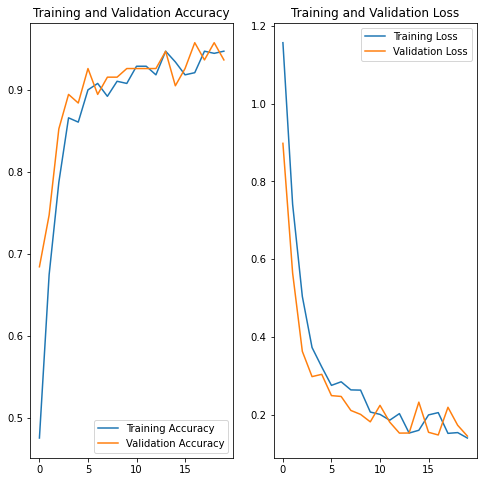

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [15]:

# img = keras.preprocessing.image.load_img(
#     'Testing/Papaya 1.png', target_size=(img_height, img_width)
# )
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

FileNotFoundError: [Errno 2] No such file or directory: 'Testing/Papaya 1.png'

In [ ]:
# model.save("model_9Oct_batch32_size64.h5")

In [36]:
model.save("model_20Oct_batch32_size64_2.h5")